<h1><center> Analyzing the effect of mechanical properties of cellular processes on
cellular packing patterns using unsupervised machine learning </center></h1>
<h2><center> SC9502B Project </center></h2>
<h3><center> Yasamin Modabber </center></h3>
<h2><center> Student ID : 251390444 </center></h3>
<link rel="stylesheet" type="text/css" href="./text.css">

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import random
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15504\600033744.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


To quantify local structure of our cellular systems, we used the g3(r,θ) distribution function, which is defined as the probability of finding a particle at a distance r from a reference particle at an angle θ. Some necessary functions are included in the python file proj.py. There, I read the data from the input files I collect using CellSim3D software [1], calculate the g_3 distribution and plot the density plot. Functions needed for analyzing the system are also included there. In this file, I go through the process of how we extract and analyze the data.

 First, lets perform a sample calcultion of g3 distribution for random points on 2D plane:

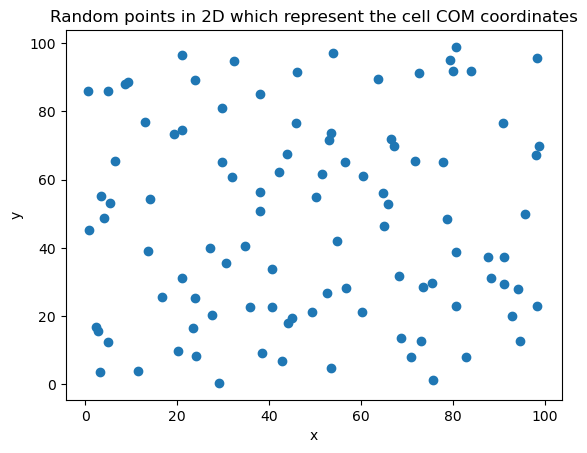

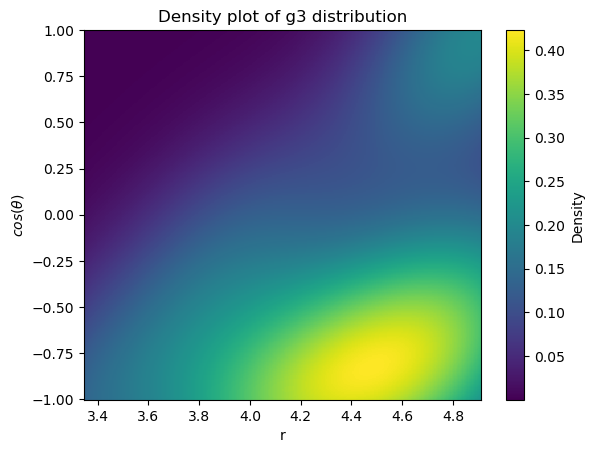

In [6]:
def random_points(n):
    points = []
    for i in range(n):
        x = random.uniform(0, 100)
        y = random.uniform(0, 100)
        points.append([x,y])
    return points

def plot_points(points):
    x = [i[0] for i in points]
    y = [i[1] for i in points]
    plt.title('Random points in 2D which represent the cell COM coordinates')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.scatter(x, y)
    plt.show()

def g3_distribution(com_coordinates,cut_off_radius): 
    r=[]
    cos_theta=[]
    for B in com_coordinates:
        #an array with all coordinates except the current one
        other_coordinates = [i for i in com_coordinates if i != B]
        dist = [np.linalg.norm(np.array(B) - np.array(i)) for i in other_coordinates]
        #find min index
        min_index = dist.index(min(dist))
        A = other_coordinates[min_index] #the closest Neighboring atom to B
        other_coordinates.remove(A)
        #find the atom C in the cutoff range
        C = [i for i in other_coordinates if np.linalg.norm(np.array(B) - np.array(i)) < cut_off_radius]
        if C:
            #calculate the angle between the vectors AB and AC
            AB = np.array(B) - np.array(A)
            AC = np.array(B) - np.array(C)
            for i in range(len(AC)):
                r.append(np.linalg.norm(AC[i]))
                cos_theta.append(np.dot(AB,AC[i])/(np.linalg.norm(AB)*np.linalg.norm(AC[i])))
    #The density plots
    x = np.array(r)
    y = np.array(cos_theta)
    nbins=300
    k = gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    # Make the plot
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
    plt.colorbar(label='Density')
    plt.title('Density plot of g3 distribution')
    plt.xlabel('r')
    plt.ylabel('$cos(\\theta)$')
    plt.show()


coords=random_points(100)
plot_points(coords)
g3_distribution(coords,5)

After calculating the $g_3$ distribution finction for each system, we calculate the Similarity Matrix using the scikit-image or skimage library. We choose the same number of windows as the one used by Matthew Davies et.all [2]. The data range will also be set to the maximal density value in all compared g3 distributions.

Minimim value in the distributions:  3.631094533338783e-75
Maximum value in the distributions:  1.2354629486337785
[[1.         0.97413242 0.95211179 ... 0.84655    0.85888155 0.87692878]
 [0.97413242 1.         0.97534225 ... 0.89646063 0.90885587 0.9226465 ]
 [0.95211179 0.97534225 1.         ... 0.9189366  0.9305049  0.94007575]
 ...
 [0.84655    0.89646063 0.9189366  ... 1.         0.98974684 0.98194943]
 [0.85888155 0.90885587 0.9305049  ... 0.98974684 1.         0.9806798 ]
 [0.87692878 0.9226465  0.94007575 ... 0.98194943 0.9806798  1.        ]]
Maximum similarity index: 1.0
Minimum similarity index: 0.6848445843769525


Text(0, 0.5, 'j')

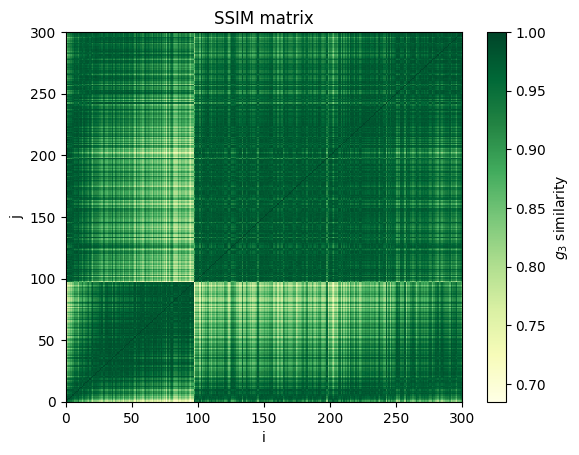

In [2]:
def SSIM_metric(dist_1,dist_2,maximal,minimal):
    return structural_similarity(dist_1,dist_2, data_range= maximal - minimal ,win_size=7)

# We Load the data from csv files
data = pd.read_csv("g3_dist_frac_gv1.csv") # s_f is changed for intermembrane friction and Medium friction of 1
data2 = pd.read_csv("g3_dist_gamma_and_vis.csv") #intermembrane friction and Medium friction is changed for s_f=0.04    vis_damp and gamma
#data4 = pd.read_csv("g3_dist_stiff.csv")
data= pd.concat([data, data2],axis=1)
#data= pd.concat([data, data3],axis=1)

data = data.to_numpy()
#print the maximum and minimum value in the data
maximal=0
minimal=1

for i in range(0,len(data[0])):
    for j in range(0,len(data)):
        if data[j][i]>maximal:
            maximal=data[j][i]
        if data[j][i]<minimal:
            minimal=data[j][i]

print("Minimim value in the distributions: " ,minimal)
print( "Maximum value in the distributions: " ,maximal)


bins_r=401
bins_theta=201
cut_off_r=2
xi, yi = np.mgrid[0:cut_off_r:bins_r*1j, -1:1:bins_theta*1j] # this creates a grid of points

# Function to see the density function of a specific distribution
def plot_dist(i):
    zi = np.reshape(data[:,i], xi.shape)
    plt.pcolormesh(xi, yi, zi, shading='auto')
    #plt.colorbar(label='Density')
    plt.title('Density plot of g3 distribution')
    plt.xlabel('r')
    plt.ylabel('$cos(\\theta)$')
    plt.show()
#Works!

#The SSIM matrix:
SSIM_mat=np.zeros((len(data[0]),len(data[0])))
for i in range(0,len(data[0])):
    zi1 = np.reshape(data[0:,i], xi.shape)
    for j in range(0,len(data[0])):
        zi2 = np.reshape(data[0:,j], xi.shape)
        SSIM_mat[i,j]= (SSIM_metric(zi1,zi2,maximal,minimal))

print(SSIM_mat)

print( "Maximum similarity index:" , SSIM_mat.max())
print( "Minimum similarity index:" , SSIM_mat.min())
plt.figure()
plt.pcolormesh(SSIM_mat, shading="flat",cmap='YlGn')
plt.colorbar(label='$g_3$ similarity')
plt.title('SSIM matrix')
plt.xlabel('i')
plt.ylabel('j')

array([[1.        , 0.94826484, 0.90422358, ..., 0.69310001, 0.71776311,
        0.75385756],
       [0.94826484, 1.        , 0.9506845 , ..., 0.79292126, 0.81771175,
        0.845293  ],
       [0.90422358, 0.9506845 , 1.        , ..., 0.8378732 , 0.86100981,
        0.88015151],
       ...,
       [0.69310001, 0.79292126, 0.8378732 , ..., 1.        , 0.97949369,
        0.96389885],
       [0.71776311, 0.81771175, 0.86100981, ..., 0.97949369, 1.        ,
        0.96135961],
       [0.75385756, 0.845293  , 0.88015151, ..., 0.96389885, 0.96135961,
        1.        ]])

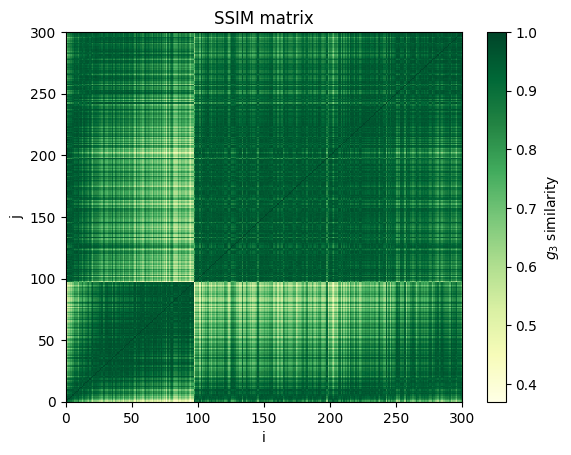

In [3]:
#Lets re-scale the SSIM matrix to set a bigger distance between values
plt.figure()
plt.pcolormesh((SSIM_mat-0.5)*2, shading="flat",cmap='YlGn')
plt.colorbar(label='$g_3$ similarity')
plt.title('SSIM matrix')
plt.xlabel('i')
plt.ylabel('j')
(SSIM_mat-0.5)*2

N x N similarity matrix for all distributions

In [17]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Convert similarity matrix to distance matrix
distance_matrix = 1 - (SSIM_mat-0.5)*2
# Instantiate DBSCAN
dbscan = DBSCAN(eps=0.15, min_samples=2)
# Fit the model to the distance matrix
dbscan.fit(distance_matrix)
labels = dbscan.labels_
print("s_f range:", labels[:98])
print("vis range:", labels[98:199])
print("gamma range:", labels[199:])


s_f data: [ 0  1  2  2  2  2  3 -1  3  2 -1  3  4 -1  3  5  6  7  8  9  7  9  9  9
  4  7  7  7  6  9  7  7  7  7  7 10  7 11  7  7  7  7  7 12  7  7  7  7
 13  7  7  7 14  7 13  7 13 13 14  7  7 13  7 15 13 16  7 13 15 14 13 -1
  7 12 16 12 17 15 18 13  7 16 -1 18 18 13 16 13 12 12 16 16 12 18 17 16
 16  0]
vis data: [ 2  2  2 -1  3 19  2  2  2  3  2  2 20  2 -1  2  3  2  2  2 -1  2  3  3
 21 20  2  3  8  3 -1  2  2 19  2 10  2  2  3  2  2 22  2 19 22  2 -1 -1
  2  2  2  2  2  2  2  2  3  3  3  2  2  2  1  2  2 23 -1  3  2  3  2  2
  2  2 -1  2  1  2  2  2  2  3  2  2 -1  2  2  2  3  2  2  2  2  3  3  2
  2  2  2  4  1]
gamma data: [ 2  2  1 -1  2  2 23  3  3 20  3  2  2  2  3  2  3  3  3  2  3 21  3  2
  2  3  3  3  3  3  3 21  3  3  3  3  2  3  5  3  3 -1 24  7  2  3 -1  3
 -1 25  3  7 11  7  3  3  3  7 24  3  3  5  5 11  5  5 21 -1 11 11  3 26
 -1  3 -1 26 11 11 25  5 11 11  7  3 11  7 11 11  5  5 -1 27  7 11 11 11
 -1  5  5  5 27]


Studying the effect of medium and intercellular friction on local structure:

[[1.         0.97413242 0.95211179 ... 0.68964038 0.73786368 0.95597364]
 [0.97413242 1.         0.97534225 ... 0.73441842 0.78209504 0.97538255]
 [0.95211179 0.97534225 1.         ... 0.76750791 0.81550245 0.97447707]
 ...
 [0.68964038 0.73441842 0.76750791 ... 1.         0.97308816 0.75495224]
 [0.73786368 0.78209504 0.81550245 ... 0.97308816 1.         0.80554021]
 [0.95597364 0.97538255 0.97447707 ... 0.75495224 0.80554021 1.        ]]
Maximum similarity index: 1.0
Minimum similarity index: 0.6848445843769525


Text(0, 0.5, 'j')

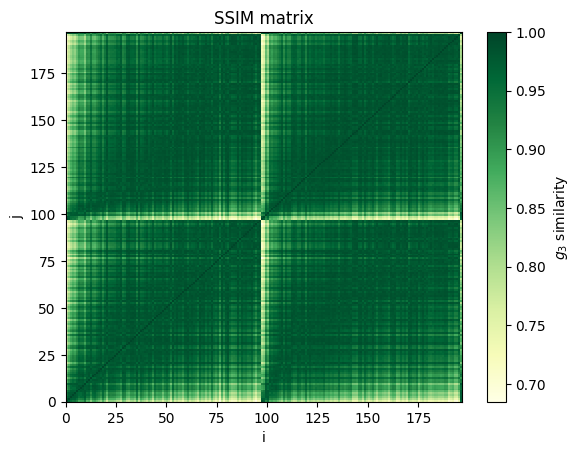

In [18]:
data_gv1 = pd.read_csv("g3_dist_frac_gv1.csv") #gamma and viscosity set to 1
data_gv2= pd.read_csv("g3_dist_frac_gv5.csv") #gamma and viscosity set to 5
data_gv= pd.concat([data_gv1, data_gv2],axis=1)
data_gv = data_gv.to_numpy()

SSIM_mat_gv=np.zeros((len(data_gv[0]),len(data_gv[0])))


for i in range(0,len(data_gv[0])):
    zi1 = np.reshape(data_gv[0:,i], xi.shape)
    for j in range(0,len(data_gv[0])):
        zi2 = np.reshape(data_gv[0:,j], xi.shape)
        SSIM_mat_gv[i,j]= (SSIM_metric(zi1,zi2,maximal,minimal))

print(SSIM_mat_gv)

print( "Maximum similarity index:" , SSIM_mat_gv.max())
print( "Minimum similarity index:" , SSIM_mat_gv.min())
plt.figure()
plt.pcolormesh(SSIM_mat_gv, shading="flat",cmap='YlGn')
plt.colorbar(label='$g_3$ similarity')
plt.title('SSIM matrix')
plt.xlabel('i')
plt.ylabel('j')

Clustering the data to find the similar elements:

In [26]:
# Convert similarity matrix to distance matrix
distance_matrix_gv = 1 - (SSIM_mat_gv-0.5)*2
# Instantiate DBSCAN
dbscan_gv = DBSCAN(eps=0.3, min_samples=2)
# Fit the model to the distance matrix
dbscan_gv.fit(distance_matrix_gv)
labels_gv = dbscan_gv.labels_
print("gamma=1 data:", labels_gv[:98])
print("gamma=5 data:", labels_gv[98:199])

gamma=1 data: [ 0 -1  1  2  1  2  3  3  3  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  0]
gamma=5 data: [-1  2  1  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3 -1]


To Study the effect of size of system on the distribution, we compare the distributions of a system with size 20 x 20 x 2 and size 40 x 40 x 2

[[1.         0.9857143  0.97057349 ... 0.87568355 0.87124909 0.95839889]
 [0.9857143  1.         0.97751465 ... 0.88393233 0.88503976 0.95953483]
 [0.97057349 0.97751465 1.         ... 0.88083189 0.87628874 0.93109926]
 ...
 [0.87568355 0.88393233 0.88083189 ... 1.         0.95774471 0.8952141 ]
 [0.87124909 0.88503976 0.87628874 ... 0.95774471 1.         0.9087205 ]
 [0.95839889 0.95953483 0.93109926 ... 0.8952141  0.9087205  1.        ]]


Text(0, 0.5, 'j')

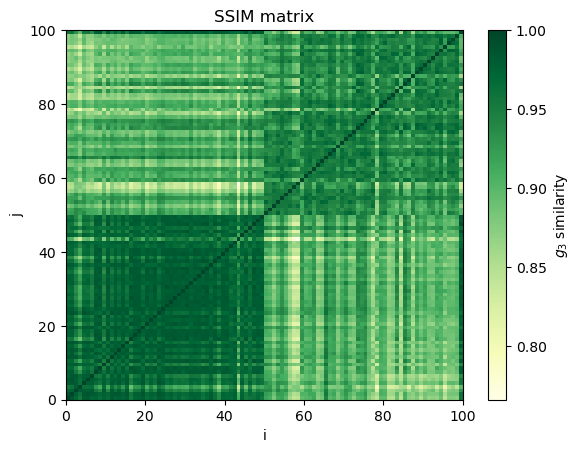

In [39]:
data_gamma_40 = pd.read_csv("g3_dist_gamma_and_vis.csv") #intermembrane friction and Medium friction is changed for s_f=0.04    vis_damp[0:101] and gamma[101:]
data_gamma_20 = pd.read_csv("g3_dist_gamma_size50.csv") 
#to eliminate the first 101 columns in the data_gamma_40
data_gamma_40 = data_gamma_40.iloc[:,101:151]
data_gamma_20 = data_gamma_20.iloc[:,:50]
data_size = pd.concat([data_gamma_40,data_gamma_20],axis=1)
data_size = data_size.to_numpy()


SSIM_mat_size=np.zeros((len(data_size[0]),len(data_size[0])))
for i in range(0,len(data_size[0])):
    zi1 = np.reshape(data_size[0:,i], xi.shape)
    for j in range(0,len(data_size[0])):
        zi2 = np.reshape(data_size[0:,j], xi.shape)
        SSIM_mat_size[i,j]= (SSIM_metric(zi1,zi2,maximal,minimal))

print(SSIM_mat_size)

plt.figure()
plt.pcolormesh(SSIM_mat_size, shading="flat",cmap='YlGn')
plt.colorbar(label='$g_3$ similarity')
plt.title('SSIM matrix')
plt.xlabel('i')
plt.ylabel('j')

This prooves the importance of choosing the right system size!

Refrences :

[1] https://github.com/SoftSimu/CellSim3D

[2] Matthew Davies, A.D. Reyes-Figueroa, Andrey A. Gurtovenko, Daniel Frankel, Mikko Karttunen, Elucidating lipid conformations in the ripple phase: Machine learning reveals four lipid populations, Biophysical Journal, Volume 122, Issue 2,2023